# Home Exercise 1 on Text Classification

Implement a **Recurrent Neural Network model** (**Vanilla RNN, GRU, and LSTM**) to predict whether a review is positive or negative.

- **Data**: [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) (the last 10% of rows serve as the test set).
- **Compare** the performance of the three models.

**Note**: Submit only a **single Jupyter Notebook file** that can handle all tasks, including data downloading, preprocessing, model training, and model evaluation. *(Submissions that do not follow the guidelines will receive a score of 0.)*

**Grading Criteria**

For valid submissions, scores will be assigned based on the **leaderboard ranking** (**strictly greater**):

- **Top 25%** → **10 points**
- **25% - 50%** → **9.0 points**
- **50% - 75%** → **8.0 points**
- **75% - 100%** → **7.0 points**


# Import Libs

In [1]:
%pip install numpy pandas tensorflow scikit-learn kagglehub nltk matplotlib


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
import os
import re
import time 
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, GRU, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Download necessary NLTK resources
nltk.download("stopwords")

# Define constants
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100
BATCH_SIZE = 64
EPOCHS = 10


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# # Download latest version
# path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

# print("Path to dataset files:", path)

# # Define the dataset path (update this if needed)
# dataset_file = os.path.join(path, "IMDB Dataset.csv")  # Ensure correct file name

# # Load the dataset
# df = pd.read_csv(dataset_file)

# # Convert sentiments to binary labels
# df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# # Split data
# train_texts, test_texts, train_labels, test_labels = train_test_split(df['review'], df['sentiment'], test_size=0.1, random_state=42)

# # Tokenization and padding
# tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
# tokenizer.fit_on_texts(train_texts)

# train_sequences = tokenizer.texts_to_sequences(train_texts)
# test_sequences = tokenizer.texts_to_sequences(test_texts)

# train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
# test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# # Convert labels to numpy arrays
# train_labels = np.array(train_labels)
# test_labels = np.array(test_labels)


In [4]:
# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)

# Define the dataset path (update this if needed)
dataset_file = os.path.join(path, "IMDB Dataset.csv")  # Ensure correct file name

# Load the dataset
df = pd.read_csv(dataset_file)

# Convert sentiments to binary labels
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

# Define stopwords and chat word dictionary
stop_words = set(stopwords.words("english"))

chat_words = {
    "afaik": "as far as i know", "afk": "away from keyboard", "asap": "as soon as possible",
    "lol": "laughing out loud", "imho": "in my honest opinion", "fyi": "for your information",
    "brb": "be right back", "btw": "by the way", "idk": "i don't know", "ttyl": "talk to you later",
    "omg": "oh my god", "gtg": "got to go", "wtf": "what the f...", "rofl": "rolling on the floor laughing",
    "u": "you", "bff": "best friends forever", "cya": "see you", "jk": "just kidding",
    "idc": "i don't care", "ily": "i love you", "imu": "i miss you"
}

# Function to expand chat words
def expand_chat_words(text, chat_words_dict):
    words = text.split()
    expanded_text = " ".join([chat_words_dict.get(word.upper(), word) for word in words])
    return expanded_text

# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)

    # Remove punctuations
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Expand chat words
    text = expand_chat_words(text, chat_words)

    # Remove stopwords
    # text = " ".join([word for word in text.split() if word not in stop_words])

    return text

# Apply preprocessing to the dataset
df["cleaned_review"] = df["review"].apply(preprocess_text)

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(df["cleaned_review"], df["sentiment"], test_size=0.1, random_state=42)

# Tokenization and padding
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 200

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

train_padded = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Print a sample preprocessed review
print("Original Review:", df["review"].iloc[0])
print("Cleaned Review:", df["cleaned_review"].iloc[0])


Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews
Original Review: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements 

In [5]:
# Define function to build models
def build_rnn_model():
    model = Sequential([
        Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
        SimpleRNN(64, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_gru_model():
    model = Sequential([
        Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
        GRU(64, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_lstm_model():
    model = Sequential([
        Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [6]:
# Train and evaluate models
models = {
    "Vanilla RNN": build_rnn_model(),
    "GRU": build_gru_model(),
    "LSTM": build_lstm_model()
}

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:
# Train, evaluate and compare
results = []
history_dict = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_train = time.time()
    history = model.fit(
        train_padded, train_labels,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(test_padded, test_labels),
        verbose=1
    )
    end_train = time.time()

    # Store history
    history_dict[name] = history.history

    # Evaluation
    start_pred = time.time()
    predictions = (model.predict(test_padded) > 0.5).astype("int32")
    end_pred = time.time()

    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions)
    recall = recall_score(test_labels, predictions)
    f1 = f1_score(test_labels, predictions)
    loss = history.history['val_loss'][-1]

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Loss": loss,
        "Training Time (s)": end_train - start_train,
        "Inference Time (s)": end_pred - start_pred
    })


Training Vanilla RNN...
Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.5006 - loss: 0.7061 - val_accuracy: 0.5098 - val_loss: 0.6923
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.5848 - loss: 0.6703 - val_accuracy: 0.5184 - val_loss: 0.7047
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6677 - loss: 0.5579 - val_accuracy: 0.5052 - val_loss: 0.7776
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.7161 - loss: 0.4498 - val_accuracy: 0.5158 - val_loss: 0.9041
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.7344 - loss: 0.4065 - val_accuracy: 0.5074 - val_loss: 1.0247
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.7539 - loss: 0.3777 - val_accuracy: 0.5070 - val_loss: 1.0752
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.7578 - loss: 0.3702 - val_accuracy: 0.5142 - val_loss: 1.0931
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy:

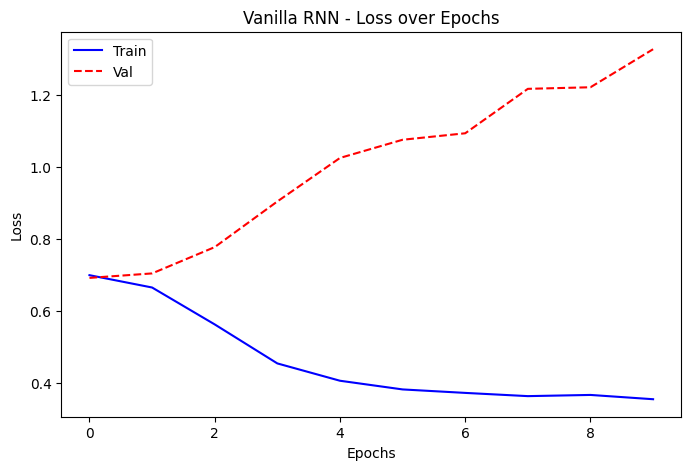

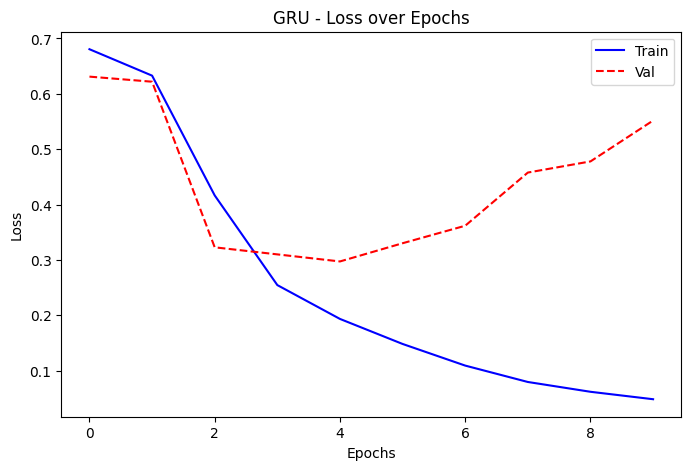

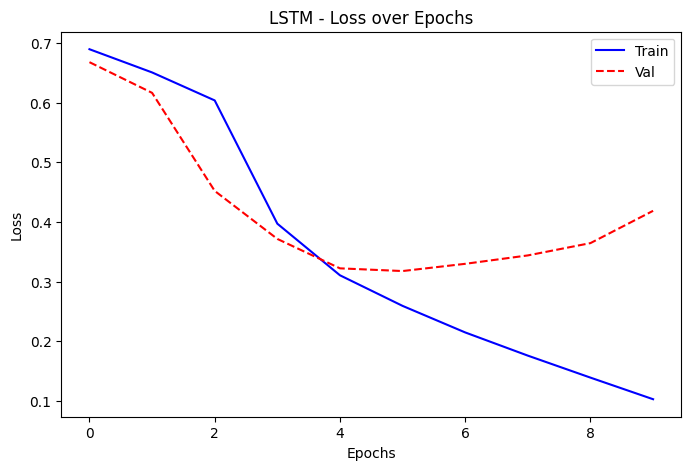

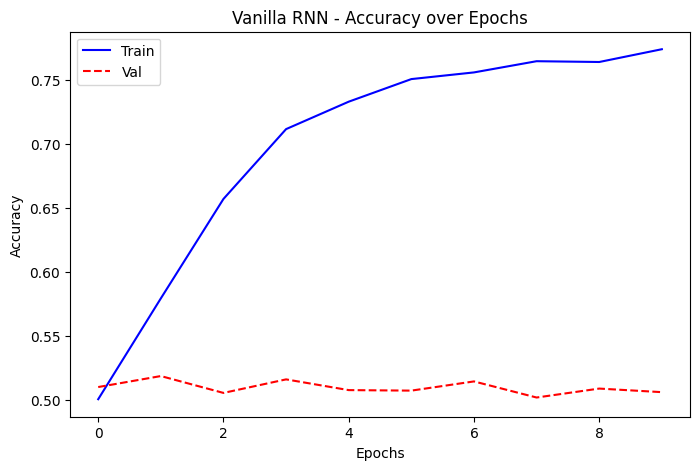

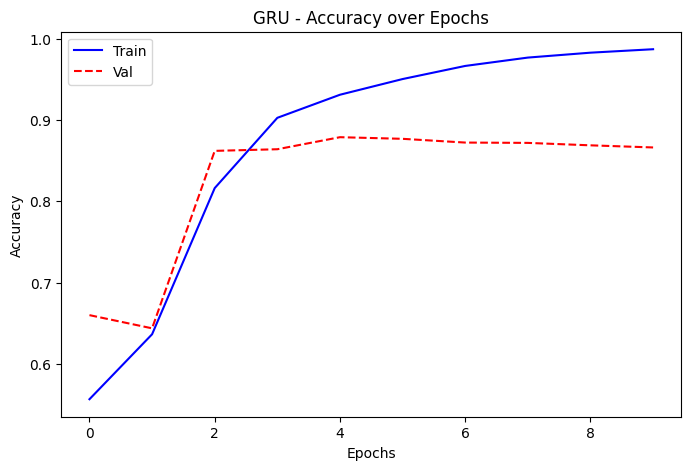

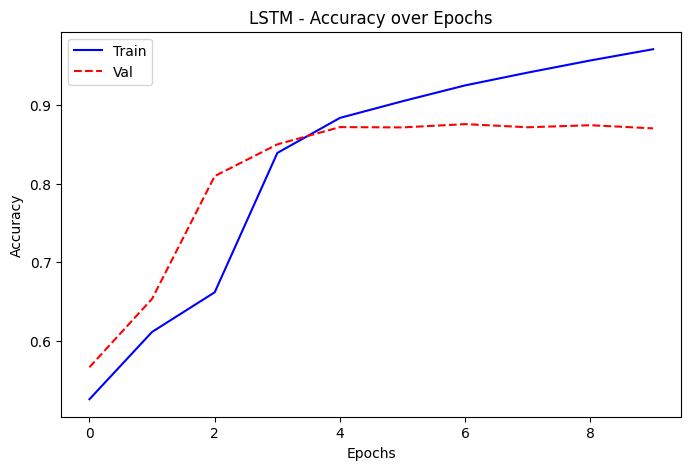

In [8]:
# Function to plot training and validation metrics separately for each model
def plot_training_and_validation_separate(history_dict, metric, val_metric, ylabel):
    for model_name, history in history_dict.items():
        plt.figure(figsize=(8, 5))
        
        plt.plot(history[metric], label=f"Train", color="blue")
        plt.plot(history[val_metric], linestyle="dashed", label=f"Val", color="red")

        plt.xlabel("Epochs")
        plt.ylabel(ylabel)
        plt.title(f"{model_name} - {ylabel} over Epochs")
        plt.legend()
        plt.show()

# Plot Loss & Accuracy separately for each model
plot_training_and_validation_separate(history_dict, "loss", "val_loss", "Loss")
plot_training_and_validation_separate(history_dict, "accuracy", "val_accuracy", "Accuracy")


In [9]:
# Compile results into a DataFrame
results_df = pd.DataFrame(results)
results_df.head()

,Model,Accuracy,Precision,Recall,F1-Score,Loss,Training Time (s),Inference Time (s)
0,Vanilla RNN,0.5058,0.508882,0.545852,0.526719,1.326075,149.227877,1.873683
1,GRU,0.8662,0.852247,0.888448,0.869971,0.551791,90.869607,0.790103
2,LSTM,0.8706,0.863919,0.882096,0.872913,0.418620,89.422005,0.858322


In [10]:
# Save the full results to CSV
results_csv_path = os.path.join(os.getcwd(), "imdb_models_performance.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"Models performance saved to: {results_csv_path}")

Models performance saved to: /kaggle/working/imdb_models_performance.csv


In [11]:
# Find the best model for each metric
best_models = {}

for metric in ["Accuracy", "Precision", "Recall", "F1-Score", "Loss", "Training Time (s)", "Inference Time (s)"]:
    if metric == "Loss" or metric == "Training Time (s)" or metric == "Inference Time (s)":
        best_models[metric] = results_df.loc[results_df[metric].idxmin(), ["Model", metric]].to_dict()  # Min loss is better
    else:
        best_models[metric] = results_df.loc[results_df[metric].idxmax(), ["Model", metric]].to_dict()  # Max other metrics are better

# Convert best models dictionary to DataFrame
best_models_df = pd.DataFrame(best_models).T.reset_index().rename(columns={"index": "Metric", "Model": "Best Model", 0: "Best Value"})
best_models_df.head(10)

,Metric,Best Model,Accuracy,Precision,Recall,F1-Score,Loss,Training Time (s),Inference Time (s)
0,Accuracy,LSTM,0.8706,NaN,NaN,NaN,NaN,NaN,NaN
1,Precision,LSTM,NaN,0.863919,NaN,NaN,NaN,NaN,NaN
2,Recall,GRU,NaN,NaN,0.888448,NaN,NaN,NaN,NaN
3,F1-Score,LSTM,NaN,NaN,NaN,0.872913,NaN,NaN,NaN
4,Loss,LSTM,NaN,NaN,NaN,NaN,0.41862,NaN,NaN
5,Training Time (s),LSTM,NaN,NaN,NaN,NaN,NaN,89.422005,NaN
6,Inference Time (s),GRU,NaN,NaN,NaN,NaN,NaN,NaN,0.790103


In [12]:
# Save the best models per metric to CSV
best_models_csv_path = os.path.join(os.getcwd(), "imdb_best_models_per_metric.csv")
best_models_df.to_csv(best_models_csv_path, index=False)
print(f"Best models per metric saved to: {best_models_csv_path}")

Best models per metric saved to: /kaggle/working/imdb_best_models_per_metric.csv
